

# **Data Mining Final Project**
# PART 4b:  Random Forest model training with SHAP analysis

# **Introduction:**
# This notebook is dedicated to advanced data analysis for credit card fraud detection.
## The main steps include:
##1. Random forest model training (part 4 code)
##2. Random Forest model training with SHAP analysis (this file)
##2. Neural network model training ( Part 5 colab)
##3. Model performance comparison (Paper)

# Step 1: Import necessary libraries


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from google.colab import files

# SHAP import


In [ ]:
import shap


# Step 2: Load the pre-processed data


In [ ]:
uploaded = files.upload()  # Upload smote_processed_data.csv and test_preprocessed.csv

Saving smote_processed_data.csv to smote_processed_data.csv


In [ ]:
uploaded = files.upload()  # Upload smote_processed_data.csv and test_preprocessed.csv

Saving test_preprocessed.csv to test_preprocessed.csv


# Use a smaller subset of training data for faster processing
# Using 20% of the training data to speed up model training


In [ ]:
# Using 20% of the training data to speed up model training
train_sample_size = int(train_data.shape[0] * 0.2)
train_data = train_data.sample(train_sample_size, random_state=42)

X_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']

# Test data (original distribution)
test_data = pd.read_csv('test_preprocessed.csv')
X_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

print("Training data shape (sampled):", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)
print("Class distribution in test set:", y_test.value_counts())

Training data shape (sampled): (72784, 29) (72784,)
Testing data shape: (56962, 29) (56962,)
Class distribution in test set: Class
0    56864
1       98
Name: count, dtype: int64


# Step 3: Train a simplified Random Forest model (fewer trees, less depth)


In [ ]:
print("Training Random Forest model (optimized version)...")
rf_model = RandomForestClassifier(
    n_estimators=50,  # Reduced from 100 to 50
    max_depth=8,      # Reduced from 10 to 8
    min_samples_split=20,  # Increased from 10 to 20
    class_weight='balanced',
    n_jobs=-1,        # Use all available cores
    random_state=42
)
rf_model.fit(X_train, y_train)
print("Model training completed.")

Training Random Forest model (optimized version)...
Model training completed.


# Step 4: SHAP Analysis for Model Interpretability



In [ ]:
print("Starting SHAP analysis...")


Starting SHAP analysis...


# 4.1: Create SHAP explainer


In [ ]:
explainer = shap.TreeExplainer(rf_model)


# 4.2: Calculate SHAP values
# Using an even smaller sample for SHAP calculation


In [ ]:
shap_sample_size = min(500, X_train.shape[0])  # Reduced from 1000 to 500
sample_indices = np.random.choice(X_train.shape[0], shap_sample_size, replace=False)
X_train_sample = X_train.iloc[sample_indices]

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_train_sample)

Calculating SHAP values...


# 4.3: Summary plot (feature importance based on SHAP)


X_train_sample shape: (500, 29)
shap_values shape: (500, 29, 2)


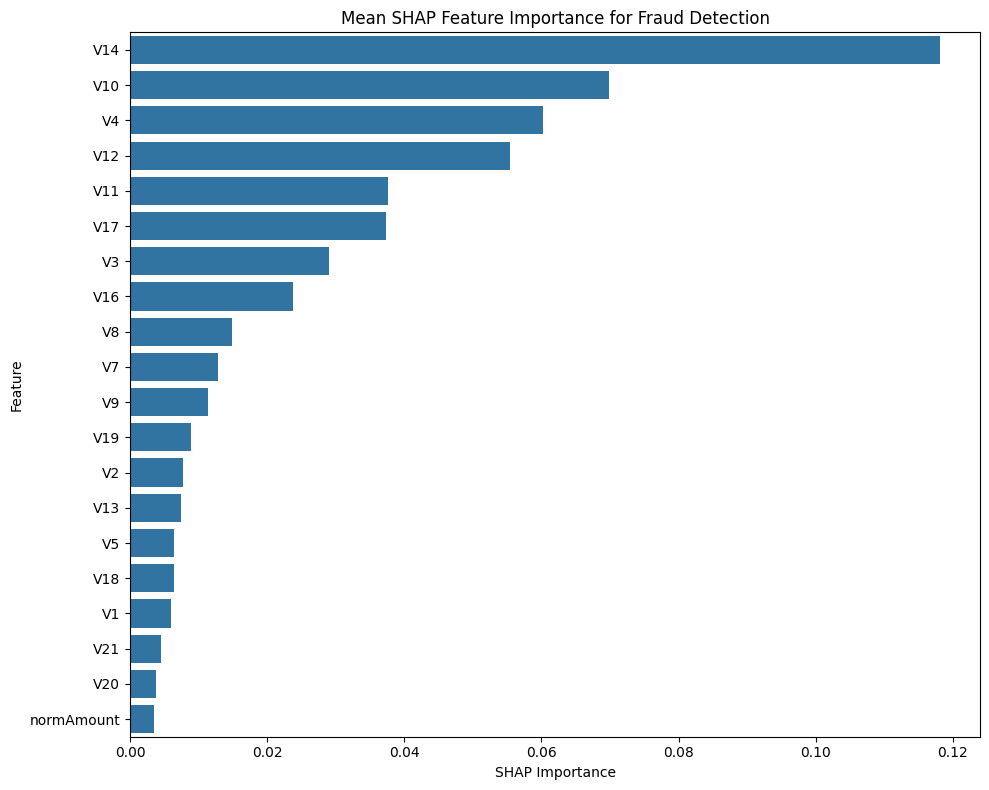

In [ ]:
# Fix for SHAP values with shape (500, 29, 2)
print(f"X_train_sample shape: {X_train_sample.shape}")
print(f"shap_values shape: {shap_values.shape}")

# For this specific shape, we need to reshape or select the appropriate slice
# Create a DataFrame with feature importance based on mean absolute SHAP values
if shap_values.shape == (500, 29, 2):
    # For binary classification, we typically want class 1 (fraud)
    # Take mean absolute values across samples for class 1
    mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(0)

    # Create DataFrame for easier plotting
    feature_importance = pd.DataFrame({
        'Feature': X_train_sample.columns,
        'SHAP Importance': mean_abs_shap
    }).sort_values('SHAP Importance', ascending=False)

    # Plot using seaborn for better visualization
    plt.figure(figsize=(10, 8))
    sns.barplot(x='SHAP Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Mean SHAP Feature Importance for Fraud Detection')
    plt.tight_layout()
    plt.show()

# Create DataFrame for feature importance visualization


In [ ]:
# Create DataFrame for feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X_train_sample.columns,
    'SHAP Importance': mean_abs_shap
}).sort_values('SHAP Importance', ascending=False)

# Print top 10 most important features
print("\nTop 10 features by SHAP importance:")
print(feature_importance.head(10))


Top 10 features by SHAP importance:
   Feature  SHAP Importance
13     V14         0.118052
9      V10         0.069895
3       V4         0.060218
11     V12         0.055469
10     V11         0.037649
16     V17         0.037350
2       V3         0.028965
15     V16         0.023812
7       V8         0.014877
6       V7         0.012901


# Create SHAP dependence plots for top 3 features


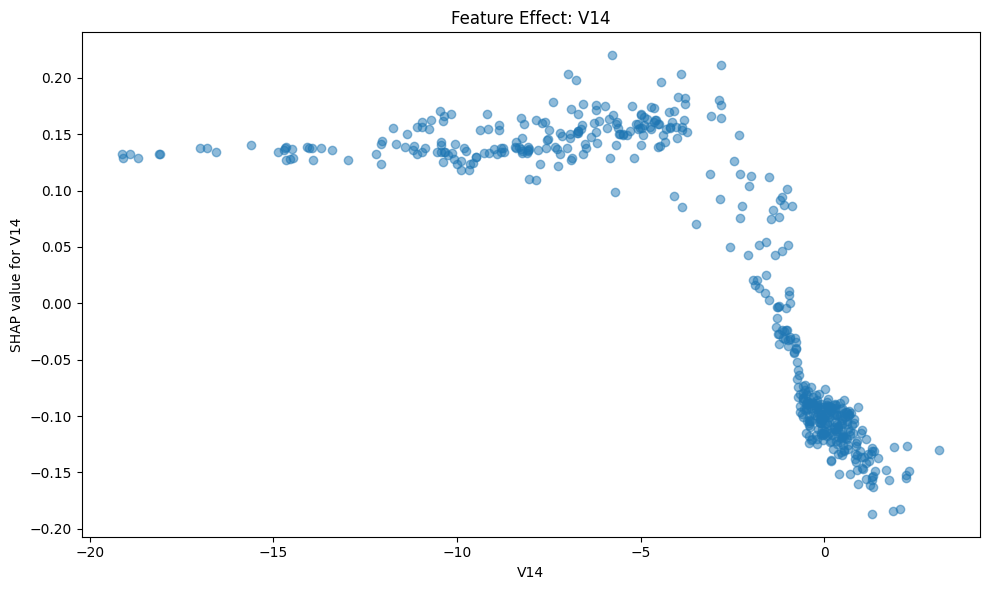

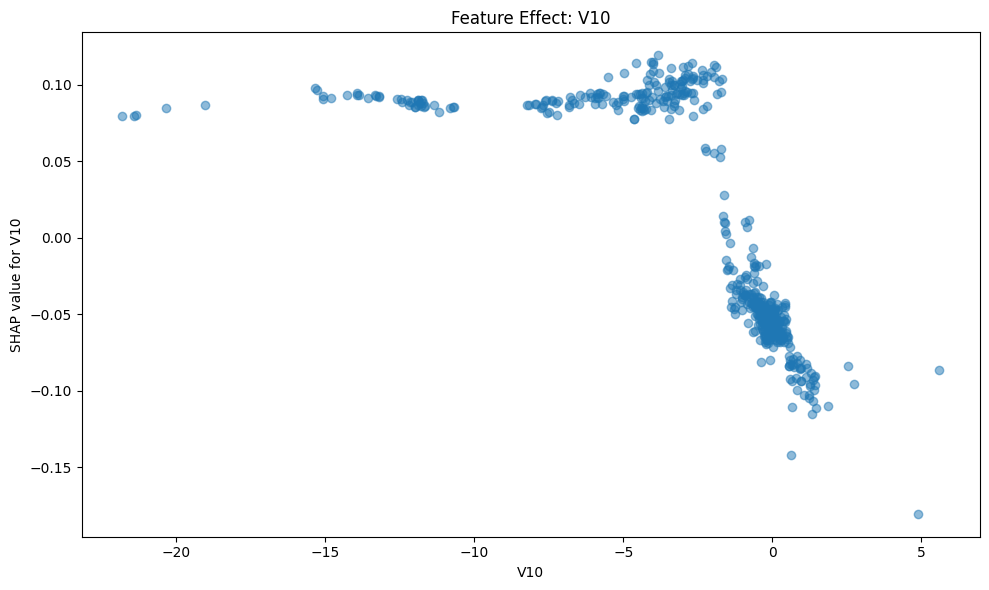

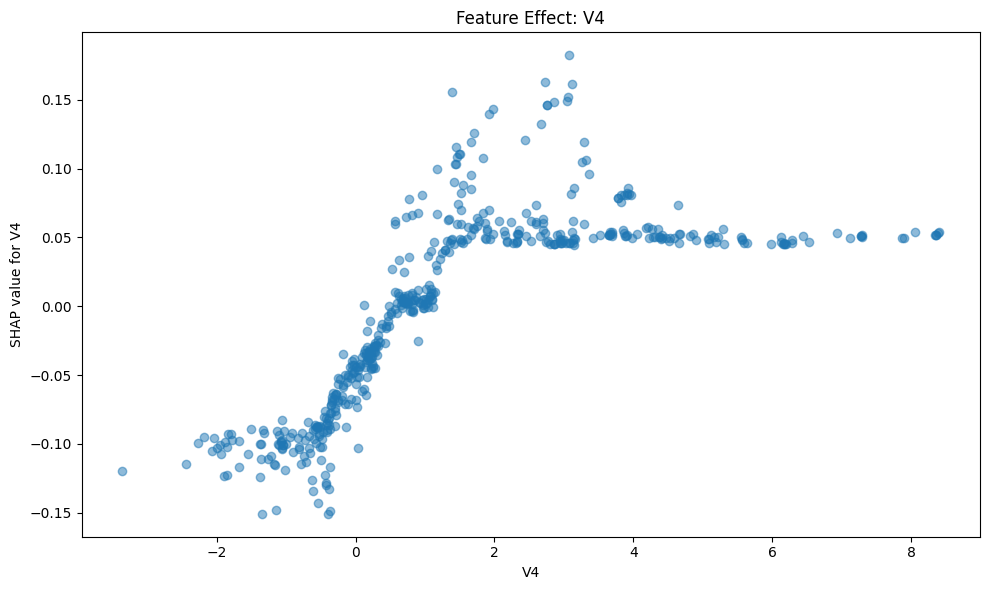

In [ ]:
top_features = feature_importance['Feature'].head(3).values

for feature in top_features:
    try:
        feature_idx = list(X_train_sample.columns).index(feature)
        feature_value = X_train_sample.iloc[:, feature_idx].values
        feature_effect = shap_values[:, feature_idx, 1]

        plt.figure(figsize=(10, 6))
        plt.scatter(feature_value, feature_effect, alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel(f'SHAP value for {feature}')
        plt.title(f'Feature Effect: {feature}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating feature effect plot for {feature}: {e}")

# Generate a single SHAP force plot for a fraud case

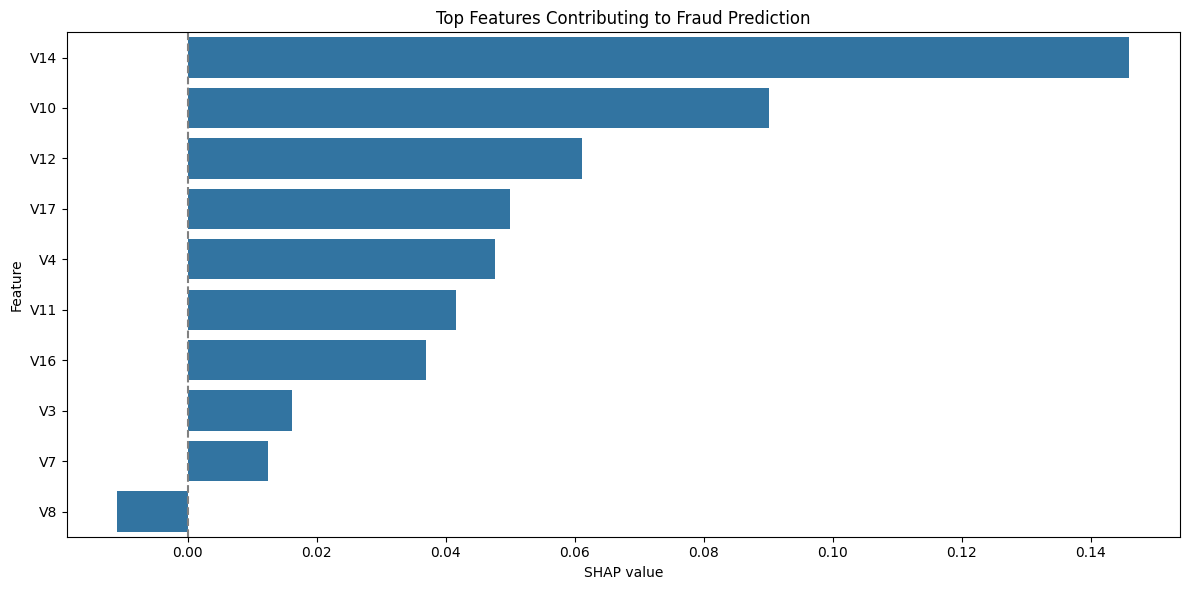


Model Performance Metrics:
Accuracy: 0.9940
Precision: 0.2048
Recall: 0.8673
F1 Score: 0.3314


In [ ]:
# Find a fraud case in the test set
if any(y_test == 1):
    try:
        fraud_idx = np.where(y_test == 1)[0][0]  # Get the first fraud case
        fraud_sample = X_test.iloc[fraud_idx:fraud_idx+1]

        # Calculate SHAP values for this sample
        fraud_shap_values = explainer.shap_values(fraud_sample)

        if isinstance(fraud_shap_values, list):
            fraud_shap = fraud_shap_values[1]
        else:
            fraud_shap = fraud_shap_values[:, :, 1]

        # For 3D SHAP values, we need to create a simple visualization
        # Create a bar plot showing the contribution of each feature
        plt.figure(figsize=(12, 6))
        features_sorted = pd.DataFrame({
            'Feature': fraud_sample.columns,
            'SHAP value': fraud_shap[0]
        }).sort_values('SHAP value', key=abs, ascending=False)

        # Plot top 10 features
        top_features = features_sorted.head(10)
        sns.barplot(x='SHAP value', y='Feature', data=top_features)
        plt.title('Top Features Contributing to Fraud Prediction')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating force plot for fraud case: {e}")
else:
    print("No fraud cases found in test set to create force plot")

# Calculate and display model performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create confusion matrix visualization



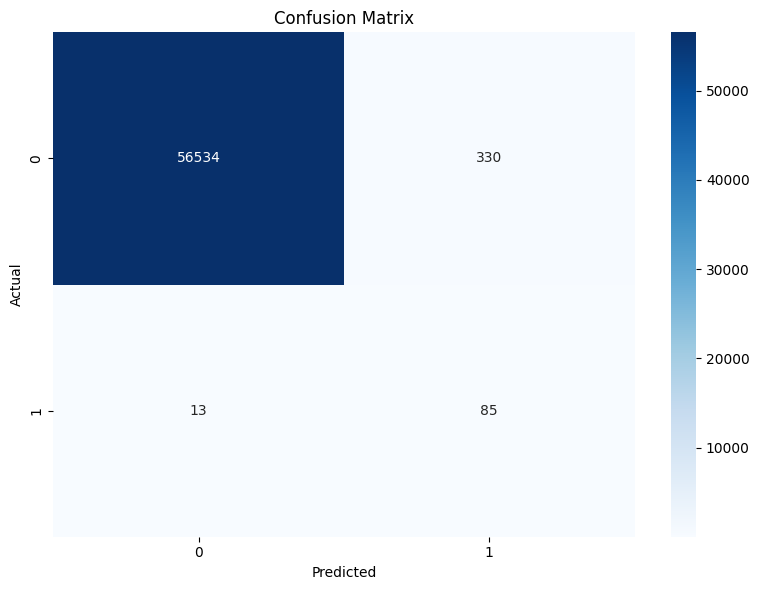

In [ ]:
# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
